# Домашняя работа 2
 Изучение GCN, GraphSAGE, GAT, GIN — на задачах "node classification" и "link prediction"




В этой домашней работе вам предстоит:

- освоить и углубить понимание нескольких графовых нейросетевых архитектур (GCN, GraphSAGE, GAT, GIN)
-  применить их к задачам классификации узлов и предсказания рёбер
- исследовать влияние глубины, скрытой размерности, оптимизации GNN на качество обучения
- построить сравнительные эксперименты и сделать собственные выводы о преимуществах разных подходов

In [3]:
# !uv pip install torch-geometric -q

In [4]:
import copy
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import RandomLinkSplit
import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/home/nikita/proga/GNN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка и визуализация данных

Датасет: Cora - Граф научных цитирований

In [8]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [12]:

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1000001)

device = torch.device('cpu')
data = data.to(device)

# Часть 1. Node Classification

### 1.1 Реализация расширенного GCN

Создайте GCN-модель с:

- тремя слоями GCNConv,
- Dropout после второго слоя,
- активацией ReLU в скрытых слоях.

**Вопросы:**

- Улучшилось ли качество на Cora в сравнении с результатом, который был получен на практике?
- Как изменилась динамика сходимости?
- Наблюдается ли переобучение?

In [695]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


In [14]:
def train_node_classification(model, data, optimizer, epochs=200, patience=20, verbose=False):
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # TRAIN
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())


        # VALIDATION
        model.eval()
        with torch.no_grad():
            model.eval()
            out = model(data.x, data.edge_index)
            pred = out[data.val_mask].argmax(dim=1)
            val_acc = (pred == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
            val_loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
            val_losses.append(val_loss)            

        if epoch % 10 == 0 and verbose:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break


    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses

def evaluate_node_classification(model, data, mask):
    """
    Оценка точности модели на подмножестве узлов, заданном маской.

    Args:
        model: обученная GNN-модель
        data: граф
        mask: булевый тензор маски (train_mask, val_mask, test_mask)

    Returns:
        float: accuracy на выбранной части графа
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
        return acc

In [ ]:
# Инициализация модели
model = GCN(dataset.num_features, dataset.num_classes, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Обучение
train_losses, val_losses = train_node_classification(model, data, optimizer, epochs=300, verbose=True)

# Оценка на тесте
test_acc = evaluate_node_classification(model, data, data.test_mask)
print(f"Accuracy на тестовой выборке: {test_acc:.4f}")

Epoch 000, Loss: 1.9497, Val Acc: 0.1900
Epoch 010, Loss: 1.8829, Val Acc: 0.4140
Epoch 020, Loss: 1.7881, Val Acc: 0.5740
Epoch 030, Loss: 1.6343, Val Acc: 0.6560
Epoch 040, Loss: 1.4614, Val Acc: 0.7120
Epoch 050, Loss: 1.2131, Val Acc: 0.7300
Epoch 060, Loss: 1.0027, Val Acc: 0.7460
Epoch 070, Loss: 0.7570, Val Acc: 0.7720
Epoch 080, Loss: 0.5638, Val Acc: 0.7860
Epoch 090, Loss: 0.4343, Val Acc: 0.7880
Epoch 100, Loss: 0.3442, Val Acc: 0.7900
Epoch 110, Loss: 0.2718, Val Acc: 0.7960
Epoch 120, Loss: 0.2028, Val Acc: 0.7820
Early stopping at epoch 129
Accuracy на тестовой выборке: 0.8020


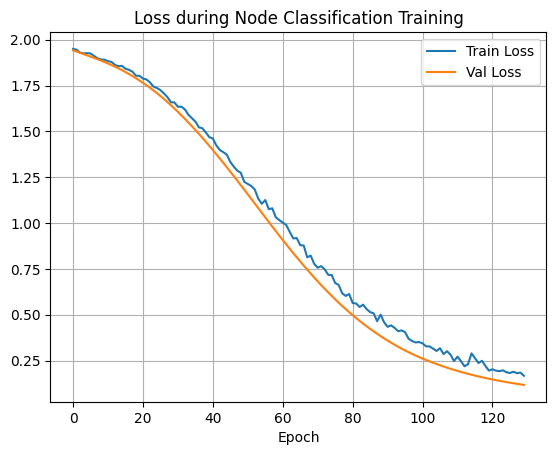

In [698]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.title("Loss during Node Classification Training")
plt.legend()
plt.grid(True)
plt.show()

1) Точность поднялась на несколько проентов!
2) В этот раз график сходимости быстрее убывает и сама модель сходится в 2 раза быстрее (вдвое меньше эпох потребовалось)!
3) Графики потерь на трейне и валидации расходятся, но разница не значительна, что в этот, что и в предыдущий раз (я неменого переписал ноутбук практики, где можно увидеть этот график). Поэтому в целом можно сказазать, что значительного переобучения не наблюдается.

### 1.2 Исследование глубины признакового пространства

Проведите эксперимент с различными значениями скрытой размерности:

```
hidden_dim = 8, 16, 32, 64
```

Постройте таблицу:

| Hidden Dim | Train Acc | Val Acc | Test Acc |
| ---------- | --------- | ------- | -------- |

**Вопросы:**

- Сравните полученные результаты
- Влияет ли размерность на качество обучения?


In [699]:
results = []
hidden_dims = [8, 16, 32, 64]
    
for hidden_dim in hidden_dims:
    model = GCN(dataset.num_features, dataset.num_classes, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    
    train_losses, val_losses = train_node_classification(model, data, optimizer, epochs=300)
    
    train_acc = evaluate_node_classification(model, data, data.train_mask)
    val_acc = evaluate_node_classification(model, data, data.val_mask)
    test_acc = evaluate_node_classification(model, data, data.test_mask)
    
    print(f"Hidden_dim: {hidden_dim}, Train_acc: {train_acc}, Val_acc: {val_acc}, Test Acc: {test_acc}")

Hidden_dim: 8, Train_acc: 0.9571428571428572, Val_acc: 0.732, Test Acc: 0.731
Hidden_dim: 16, Train_acc: 0.9785714285714285, Val_acc: 0.77, Test Acc: 0.782
Hidden_dim: 32, Train_acc: 0.9785714285714285, Val_acc: 0.768, Test Acc: 0.788
Hidden_dim: 64, Train_acc: 0.9928571428571429, Val_acc: 0.782, Test Acc: 0.799


1) Результаты росли в качестве по мере увелечения hidden_dim. 
2) Да. Так как валидационная точность и тестовая точности росли вместе в размерностью. Но к концу разница в качесвте стала меньше.

### 1.3 Исследование нормализаций

Добавьте BatchNorm / LayerNorm / PairNorm (можно комбинировать) между слоями GCN и сравните:

- скорость сходимости,
- валидационную точность,
- чувствительность к learning rate.

**Вопросы:**
- Оцените каждый вариант:
    - Улучшилась ли стабильность обучения?
    - Снизился ли эффект over-smoothing?
- Какой вариант нормализации показал себя лучше всего для данной задачи?



In [700]:
class PairNorm(torch.nn.Module):
    def __init__(self, scale=1.0, eps=1e-8):
        super().__init__()
        self.scale = scale
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        x = x - mean
        scale = torch.sqrt((x ** 2).sum(dim=1).mean() + self.eps)
        x = self.scale * x / scale
        return x
    
class GCN_Norm(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, norm_type, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        self.norm_type = norm_type
        
        if norm_type == 'batch':
            self.norm1 = nn.BatchNorm1d(hidden_dim)
            self.norm2 = nn.BatchNorm1d(hidden_dim)
        elif norm_type == 'layer':
            self.norm1 = nn.LayerNorm(hidden_dim)
            self.norm2 = nn.LayerNorm(hidden_dim)
        elif norm_type == 'pair':
            self.norm1 = PairNorm()
            self.norm2 = PairNorm()
            

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

norm_type: batch
############################
lr: 0.005
------------------------
Epoch 000, Loss: 2.2707, Val Acc: 0.1260
Epoch 010, Loss: 0.9055, Val Acc: 0.1320
Epoch 020, Loss: 0.4367, Val Acc: 0.5080
Epoch 030, Loss: 0.2550, Val Acc: 0.6980
Epoch 040, Loss: 0.1565, Val Acc: 0.7280
Epoch 050, Loss: 0.1055, Val Acc: 0.7360
Epoch 060, Loss: 0.0561, Val Acc: 0.7460
Epoch 070, Loss: 0.0466, Val Acc: 0.7460
Epoch 080, Loss: 0.0465, Val Acc: 0.7420
Early stopping at epoch 80
Test Accuracy: 0.7610
------------------------




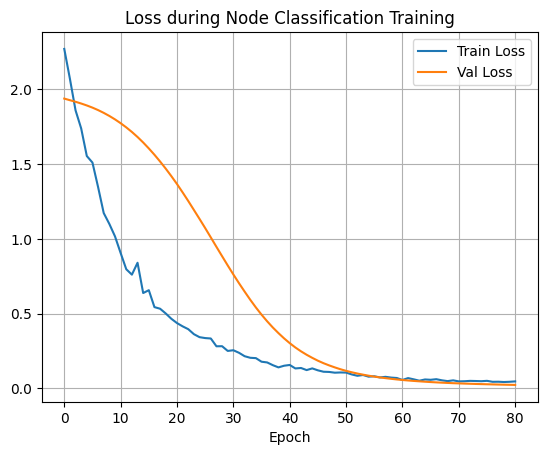

lr: 0.001
------------------------
Epoch 000, Loss: 2.2308, Val Acc: 0.1460
Epoch 010, Loss: 0.8536, Val Acc: 0.5040
Epoch 020, Loss: 0.3986, Val Acc: 0.6640
Epoch 030, Loss: 0.1958, Val Acc: 0.7140
Epoch 040, Loss: 0.1297, Val Acc: 0.7400
Epoch 050, Loss: 0.0707, Val Acc: 0.7440
Epoch 060, Loss: 0.0581, Val Acc: 0.7460
Epoch 070, Loss: 0.0623, Val Acc: 0.7460
Early stopping at epoch 76
Test Accuracy: 0.7810
------------------------




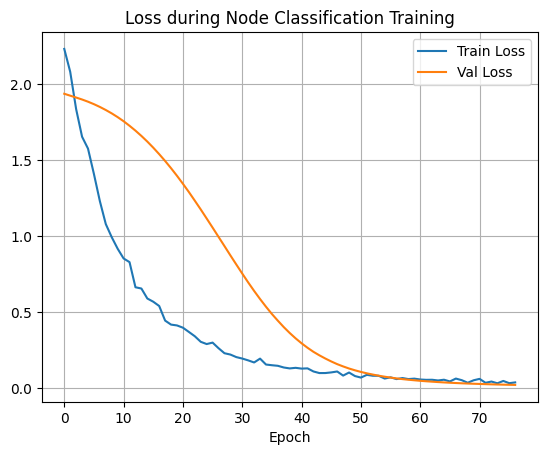

lr: 0.0005
------------------------
Epoch 000, Loss: 2.4650, Val Acc: 0.1120
Epoch 010, Loss: 0.9705, Val Acc: 0.1760
Epoch 020, Loss: 0.4223, Val Acc: 0.3740
Epoch 030, Loss: 0.2657, Val Acc: 0.6420
Epoch 040, Loss: 0.1530, Val Acc: 0.7020
Epoch 050, Loss: 0.1007, Val Acc: 0.7020
Epoch 060, Loss: 0.0867, Val Acc: 0.7100
Epoch 070, Loss: 0.0517, Val Acc: 0.7080
Epoch 080, Loss: 0.0433, Val Acc: 0.7160
Epoch 090, Loss: 0.0341, Val Acc: 0.7240
Epoch 100, Loss: 0.0228, Val Acc: 0.7220
Epoch 110, Loss: 0.0275, Val Acc: 0.7240
Epoch 120, Loss: 0.0250, Val Acc: 0.7260
Epoch 130, Loss: 0.0242, Val Acc: 0.7240
Epoch 140, Loss: 0.0176, Val Acc: 0.7220
Early stopping at epoch 143
Test Accuracy: 0.7360
------------------------




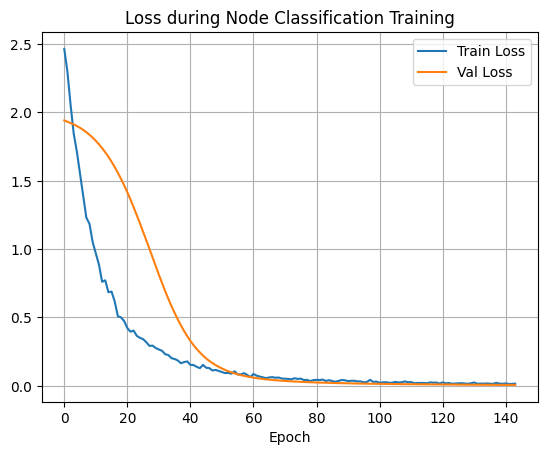

lr: 0.0001
------------------------
Epoch 000, Loss: 2.1677, Val Acc: 0.1600
Epoch 010, Loss: 0.8828, Val Acc: 0.2780
Epoch 020, Loss: 0.4049, Val Acc: 0.4480
Epoch 030, Loss: 0.2311, Val Acc: 0.6120
Epoch 040, Loss: 0.1432, Val Acc: 0.7000
Epoch 050, Loss: 0.0936, Val Acc: 0.7200
Epoch 060, Loss: 0.0637, Val Acc: 0.7260
Epoch 070, Loss: 0.0451, Val Acc: 0.7280
Epoch 080, Loss: 0.0305, Val Acc: 0.7240
Epoch 090, Loss: 0.0344, Val Acc: 0.7300
Early stopping at epoch 92
Test Accuracy: 0.7440
------------------------




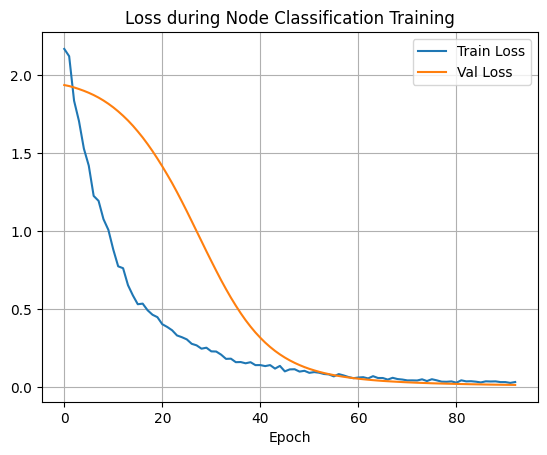

norm_type: layer
############################
lr: 0.005
------------------------
Epoch 000, Loss: 2.2369, Val Acc: 0.0940
Epoch 010, Loss: 1.0394, Val Acc: 0.6740
Epoch 020, Loss: 0.4958, Val Acc: 0.7340
Epoch 030, Loss: 0.2473, Val Acc: 0.7460
Epoch 040, Loss: 0.1371, Val Acc: 0.7560
Epoch 050, Loss: 0.1021, Val Acc: 0.7640
Epoch 060, Loss: 0.0738, Val Acc: 0.7580
Epoch 070, Loss: 0.0561, Val Acc: 0.7520
Early stopping at epoch 70
Test Accuracy: 0.7760
------------------------




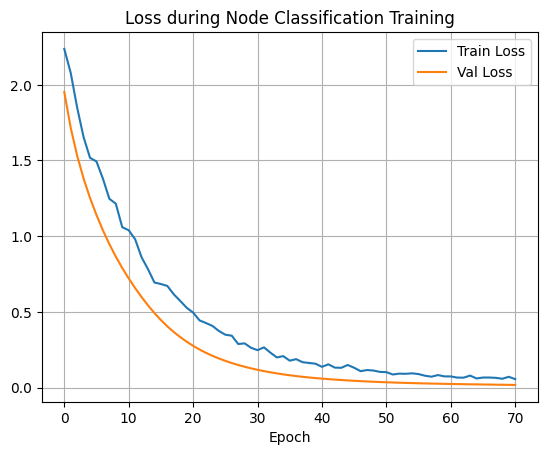

lr: 0.001
------------------------
Epoch 000, Loss: 2.3795, Val Acc: 0.1400
Epoch 010, Loss: 1.0538, Val Acc: 0.6000
Epoch 020, Loss: 0.5061, Val Acc: 0.7180
Epoch 030, Loss: 0.2843, Val Acc: 0.7620
Epoch 040, Loss: 0.1681, Val Acc: 0.7520
Early stopping at epoch 49
Test Accuracy: 0.7890
------------------------




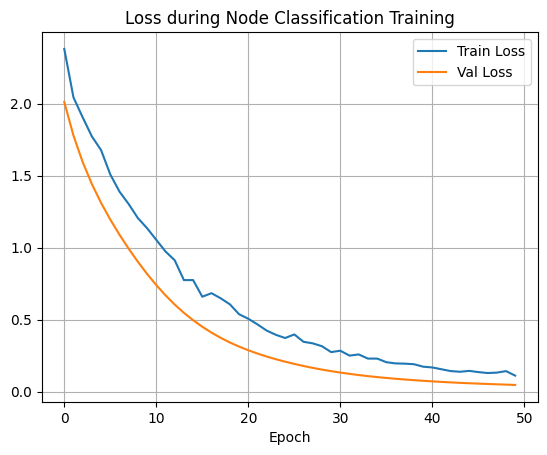

lr: 0.0005
------------------------
Epoch 000, Loss: 2.4846, Val Acc: 0.2040
Epoch 010, Loss: 1.0115, Val Acc: 0.6520
Epoch 020, Loss: 0.4883, Val Acc: 0.7260
Epoch 030, Loss: 0.2962, Val Acc: 0.7340
Epoch 040, Loss: 0.2020, Val Acc: 0.7500
Epoch 050, Loss: 0.1273, Val Acc: 0.7480
Epoch 060, Loss: 0.0992, Val Acc: 0.7520
Early stopping at epoch 62
Test Accuracy: 0.7730
------------------------




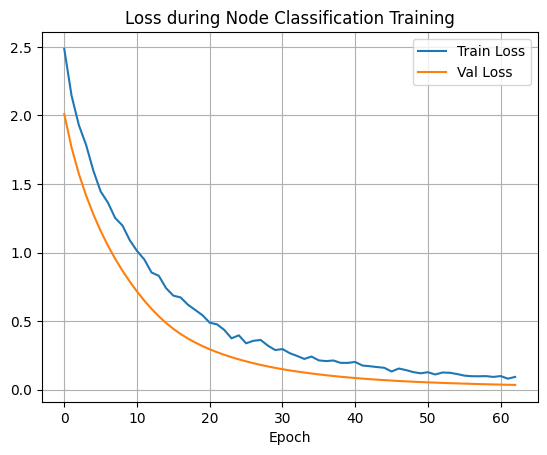

lr: 0.0001
------------------------
Epoch 000, Loss: 2.4107, Val Acc: 0.1860
Epoch 010, Loss: 1.0462, Val Acc: 0.6740
Epoch 020, Loss: 0.4671, Val Acc: 0.7520
Epoch 030, Loss: 0.2802, Val Acc: 0.7660
Epoch 040, Loss: 0.1843, Val Acc: 0.7760
Epoch 050, Loss: 0.1157, Val Acc: 0.7660
Epoch 060, Loss: 0.0776, Val Acc: 0.7660
Early stopping at epoch 60
Test Accuracy: 0.7760
------------------------




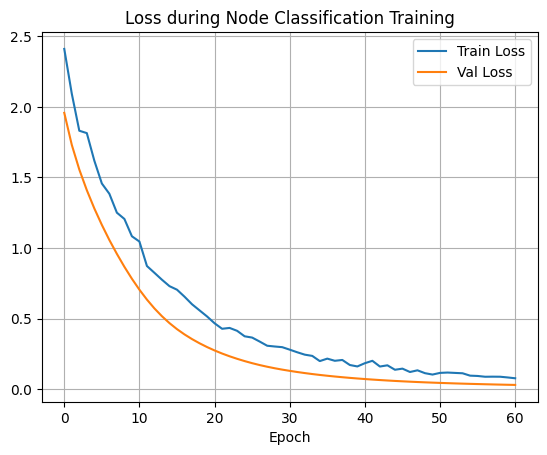

norm_type: pair
############################
lr: 0.005
------------------------
Epoch 000, Loss: 1.9583, Val Acc: 0.1000
Epoch 010, Loss: 1.7899, Val Acc: 0.5280
Epoch 020, Loss: 1.6180, Val Acc: 0.6500
Epoch 030, Loss: 1.4552, Val Acc: 0.6820
Epoch 040, Loss: 1.3001, Val Acc: 0.7100
Epoch 050, Loss: 1.1660, Val Acc: 0.7180
Epoch 060, Loss: 1.0425, Val Acc: 0.7100
Epoch 070, Loss: 0.9497, Val Acc: 0.7040
Early stopping at epoch 71
Test Accuracy: 0.7360
------------------------




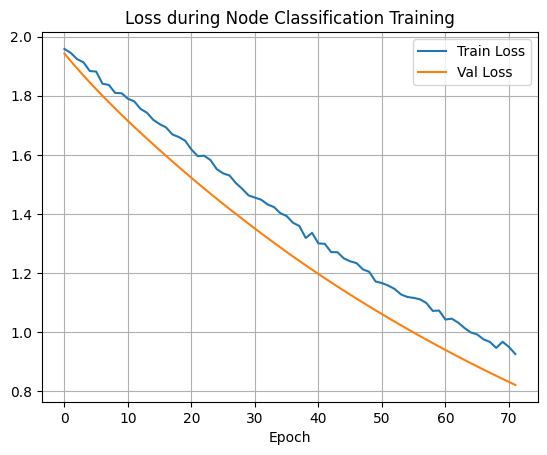

lr: 0.001
------------------------
Epoch 000, Loss: 1.9535, Val Acc: 0.1180
Epoch 010, Loss: 1.7806, Val Acc: 0.5420
Epoch 020, Loss: 1.6191, Val Acc: 0.6660
Epoch 030, Loss: 1.4553, Val Acc: 0.7000
Epoch 040, Loss: 1.2942, Val Acc: 0.7120
Epoch 050, Loss: 1.1572, Val Acc: 0.7120
Epoch 060, Loss: 1.0480, Val Acc: 0.7060
Early stopping at epoch 64
Test Accuracy: 0.7590
------------------------




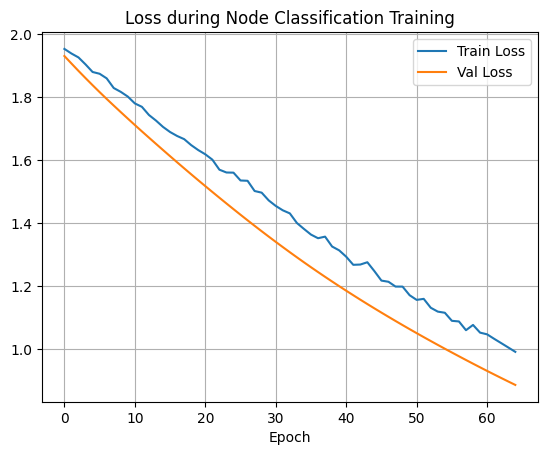

lr: 0.0005
------------------------
Epoch 000, Loss: 1.9478, Val Acc: 0.2000
Epoch 010, Loss: 1.7592, Val Acc: 0.6020
Epoch 020, Loss: 1.6051, Val Acc: 0.7100
Epoch 030, Loss: 1.4237, Val Acc: 0.7320
Epoch 040, Loss: 1.2883, Val Acc: 0.7260
Epoch 050, Loss: 1.1393, Val Acc: 0.7140
Early stopping at epoch 50
Test Accuracy: 0.7490
------------------------




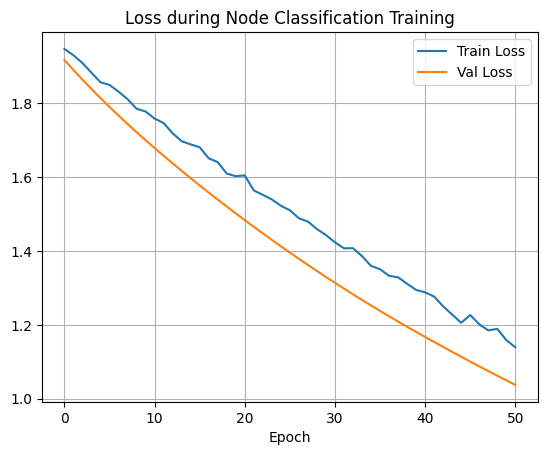

lr: 0.0001
------------------------
Epoch 000, Loss: 1.9382, Val Acc: 0.2140
Epoch 010, Loss: 1.7552, Val Acc: 0.6520
Epoch 020, Loss: 1.6003, Val Acc: 0.7120
Epoch 030, Loss: 1.4199, Val Acc: 0.7440
Epoch 040, Loss: 1.2749, Val Acc: 0.7480
Epoch 050, Loss: 1.1349, Val Acc: 0.7300
Early stopping at epoch 51
Test Accuracy: 0.7460
------------------------




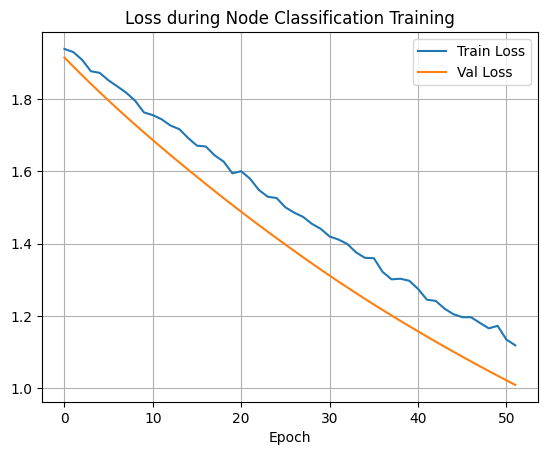

In [719]:
# Результаты во время и после обучения, а также грфики сходимости (их много)

norm_types  = ["batch", "layer", "pair"]

for norm_type in norm_types:
    print(f"norm_type: {norm_type}")
    print("############################")
    for lr in [0.005, 0.001, 0.0005, 0.0001]:
        print(f"lr: {lr}")
        
        model = GCN_Norm(dataset.num_features, dataset.num_classes, 128, norm_type).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
        
        print('------------------------')
        train_losses, val_losses = train_node_classification(model, data, optimizer, epochs=300, verbose=True)
        test_acc = evaluate_node_classification(model, data, data.test_mask)
        print(f"Test Accuracy: {test_acc:.4f}")
        print('------------------------\n\n')
        
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel("Epoch")
        plt.title("Loss during Node Classification Training")
        plt.legend()
        plt.grid(True)
        plt.show()

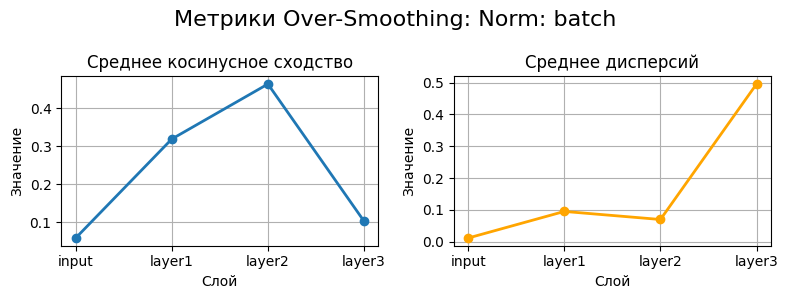

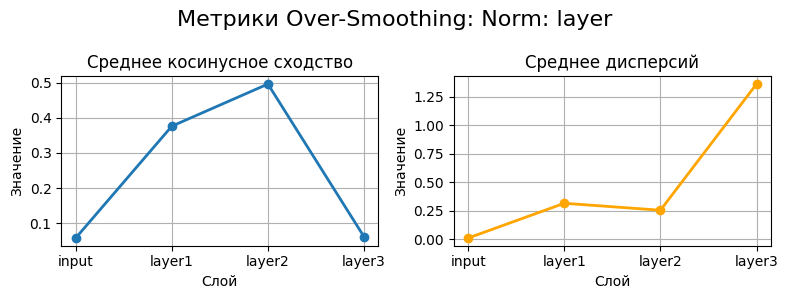

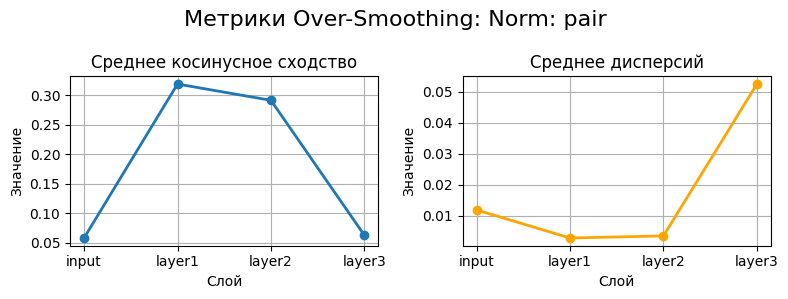

In [702]:
def compute_smoothing_metrics(model, data, n_layers=-1):
    model.eval()
    metrics = {}
    layers = []
    
    with torch.no_grad():
        x = data.x
        layers.append(('input', x))
        for i in range(n_layers):
            x = getattr(model, f"conv{i+1}", None)(x, data.edge_index)
            if i + 1 < n_layers:
                x = getattr(model, f"norm{i+1}", None)(x)
                x = F.relu(x)
            layers.append((f'layer{i+1}', x))

        for name, x in layers:
            x = x[data.test_mask]
            
            x_norm = F.normalize(x, p=2, dim=1)
            cosine_sim = torch.mm(x_norm, x_norm.t())
            avg_cosine_sim = cosine_sim.mean().item()
            
            var_per_dim = x.var(dim=0)
            avg_var = var_per_dim.mean().item()
            
            metrics[name] = {
                'avg_cosine_similarity': avg_cosine_sim,
                'avg_variance': avg_var,
            }
    
    return metrics

def plot_smoothing_metrics(metrics_dict, model_name, n_layers=-1):
    layers = ['input']
    for i in range(n_layers):
        layers.append(f'layer{i+1}')
    
    _, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    vals1 = [metrics_dict[layer]['avg_cosine_similarity'] for layer in layers]
    axes[0].plot(layers, vals1, marker='o', linewidth=2)
    axes[0].set_title('Среднее косинусное сходство')
    axes[0].set_xlabel('Слой')
    axes[0].set_ylabel('Значение')
    axes[0].grid(True)
    
    vals2 = [metrics_dict[layer]['avg_variance'] for layer in layers]
    axes[1].plot(layers, vals2, marker='o', linewidth=2, color='orange')
    axes[1].set_title('Среднее дисперсий')
    axes[1].set_xlabel('Слой')
    axes[1].set_ylabel('Значение')
    axes[1].grid(True)
    
    plt.suptitle(f'Метрики Over-Smoothing: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
norm_types = ['batch', 'layer', 'pair']
for norm_type in norm_types:        
    model = GCN_Norm(
        num_features=dataset.num_features,
        hidden_dim=128,
        num_classes=dataset.num_classes,
        norm_type=norm_type,
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)        
    _, _ = train_node_classification(model, data, optimizer, epochs=300)
    
    metrics = compute_smoothing_metrics(model, data, 3)
    plot_smoothing_metrics(metrics, f"Norm: {norm_type}", 3)

1) 
    а) Какой-то разницы в стабильности я не заметил, но вот сходимость стала быстрее. \
    б) По графикам с метриками по эмбеддингам с разных слоев можно заметить, что PairNorm, как и ожидалось, оказалось самым эффективным методом в борьбе с over-smoothing'ом. Но по метрикам точности он проигрывает.
2)  В точности лучше всего себя показала модель с LayerNorm. 

### 1.4 Residual Connections (Skip Connections)

Добавление остаточных связей:

$
h_v^{(k+1)} = h_v^{(k)} + \text{GCNLayer}(h_v^{(k)})
$

— улучшает распространение градиентов и сохраняет индивидуальность узлов.

Задание:
1. Добавьте residual connection между слоями GCN.
2. Проверьте, можно ли теперь использовать более глубокую модель (3–4 слоя)

**Вопросы:**

* Улучшается ли обучение GCN?
* Перестаёт ли сеть «слишком усреднять» узлы?



In [703]:
class PairNorm(torch.nn.Module):
    def __init__(self, scale=1.0, eps=1e-8):
        super().__init__()
        self.scale = scale
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        x = x - mean
        scale = torch.sqrt((x ** 2).sum(dim=1).mean() + self.eps)
        x = self.scale * x / scale
        return x
    
class GCN_Res(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, num_features)
        self.conv4 = GCNConv(num_features, num_classes)

        self.dropout = dropout
        self.norm_type = norm_type
        
        self.norm1 = PairNorm()
        self.norm2 = PairNorm()
        self.norm3 = nn.LayerNorm(num_features)
            

    def forward(self, in_x, edge_index):
        x = self.conv1(in_x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x += in_x
        
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

In [704]:
model = GCN_Res(dataset.num_features, dataset.num_classes, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

train_losses, val_losses = train_node_classification(model, data, optimizer, epochs=300, verbose=True)

test_acc = evaluate_node_classification(model, data, data.test_mask)
print(f"Accuracy на тестовой выборке: {test_acc:.4f}")

Epoch 000, Loss: 2.3608, Val Acc: 0.3800
Epoch 010, Loss: 0.1638, Val Acc: 0.7680
Epoch 020, Loss: 0.0296, Val Acc: 0.7720
Epoch 030, Loss: 0.0134, Val Acc: 0.7600
Early stopping at epoch 34
Accuracy на тестовой выборке: 0.8050


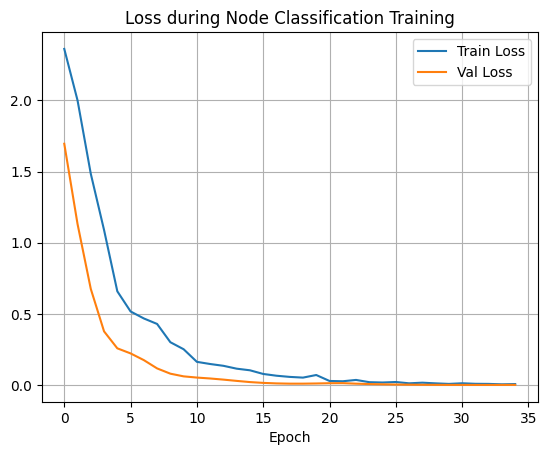

In [705]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.title("Loss during Node Classification Training")
plt.legend()
plt.grid(True)
plt.show()

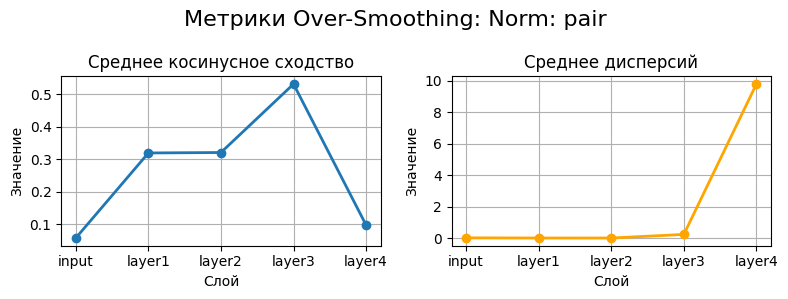

In [706]:
metrics = compute_smoothing_metrics(model, data, 4)
plot_smoothing_metrics(metrics, f"Norm: {norm_type}", 4)

1) Качество модели не повысилось. Сходится еще быстрее.
2) Различимость эмбеддингов хорошая.

### 1.5 DropEdge

DropEdge случайно удаляет часть рёбер:

$
\tilde{E} = \text{Dropout}(E)
$

Этот метод:
- уменьшает степень узлов,
- снижает oversmoothing,
- действует как регуляризация.

Задание:
1. Реализуйте DropEdge: случайно удаляйте `p` рёбер на каждой эпохе.
2. Обучите GCN на этом изменённом графе.
3. Постройте метрики качества.

**Вопросы:**
- Улучшается ли устойчивость сети к переобучению?
- Какой процент удаляемых рёбер оптимален?

In [11]:
def drop_edge(data, p):
        edge_index = data.edge_index
        num_edges = edge_index.shape[1]
        num_keep = int((1 - p) * num_edges)
        keep_indices = torch.randperm(num_edges)[:num_keep]
        new_edge_index = edge_index[:, keep_indices]
        data.edge_index = new_edge_index
        return data

class GCN_DropEdge(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

def train_with_dropedge(model, data, optimizer, p=0.2, epochs=200, patience=20, verbose=False):
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        data_transformed = drop_edge(data.clone(), p)
        
        model.train()
        optimizer.zero_grad()

        out = model(data_transformed.x, data_transformed.edge_index)
        loss = F.cross_entropy(out[data_transformed.train_mask], data_transformed.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())


        # VALIDATION
        model.eval()
        with torch.no_grad():
            model.eval()
            out = model(data_transformed.x, data_transformed.edge_index)
            pred = out[data_transformed.val_mask].argmax(dim=1)
            val_acc = (pred == data_transformed.y[data_transformed.val_mask]).sum().item() / data_transformed.val_mask.sum().item()
            val_loss = F.cross_entropy(out[data_transformed.train_mask], data_transformed.y[data_transformed.train_mask])
            val_losses.append(val_loss)            

        if epoch % 10 == 0 and verbose:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses

Epoch 000, Loss: 1.9580, Val Acc: 0.1180
Epoch 010, Loss: 1.7450, Val Acc: 0.5320
Epoch 020, Loss: 1.4239, Val Acc: 0.7180
Epoch 030, Loss: 0.8923, Val Acc: 0.7720
Epoch 040, Loss: 0.4400, Val Acc: 0.7880
Epoch 050, Loss: 0.2154, Val Acc: 0.7840
Epoch 060, Loss: 0.1262, Val Acc: 0.7740
Early stopping at epoch 67
Accuracy на тестовой выборке: 0.8150


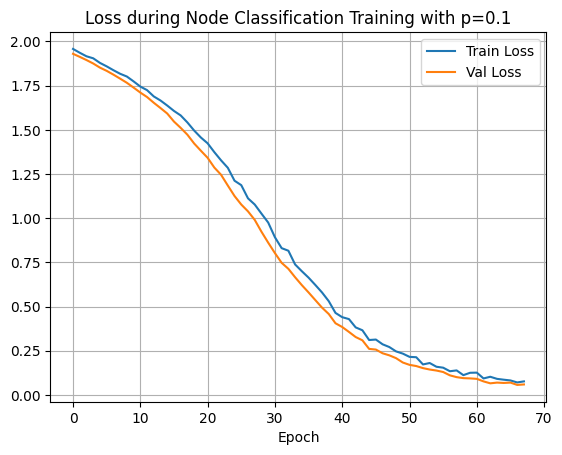

Epoch 000, Loss: 0.2922, Val Acc: 0.8020
Epoch 010, Loss: 0.1517, Val Acc: 0.7680
Epoch 020, Loss: 0.0982, Val Acc: 0.7640
Early stopping at epoch 20
Accuracy на тестовой выборке: 0.8120


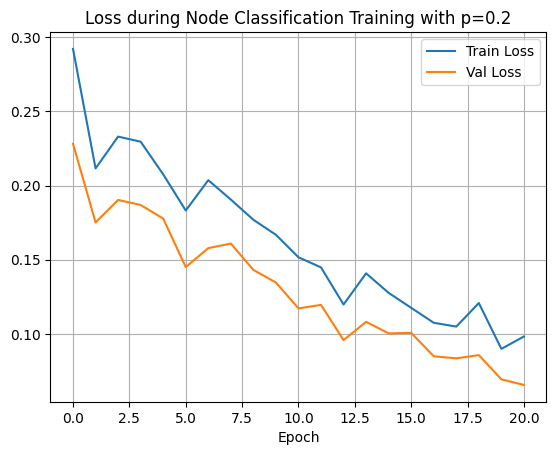

Epoch 000, Loss: 0.2435, Val Acc: 0.7800
Epoch 010, Loss: 0.1601, Val Acc: 0.7620
Epoch 020, Loss: 0.1078, Val Acc: 0.7700
Epoch 030, Loss: 0.0865, Val Acc: 0.7640
Epoch 040, Loss: 0.0581, Val Acc: 0.7720
Early stopping at epoch 42
Accuracy на тестовой выборке: 0.8110


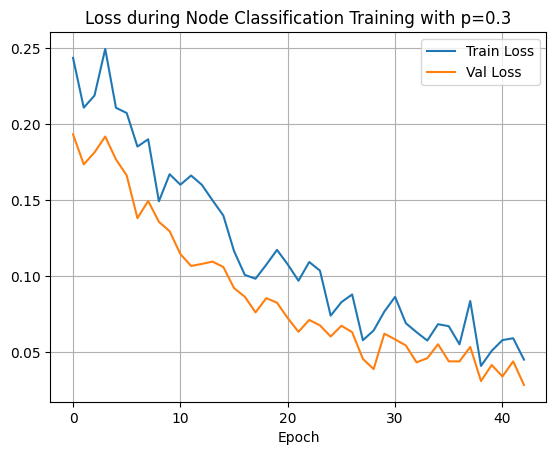

Epoch 000, Loss: 0.1229, Val Acc: 0.7620
Epoch 010, Loss: 0.0775, Val Acc: 0.7560
Epoch 020, Loss: 0.0686, Val Acc: 0.7400
Early stopping at epoch 20
Accuracy на тестовой выборке: 0.8090


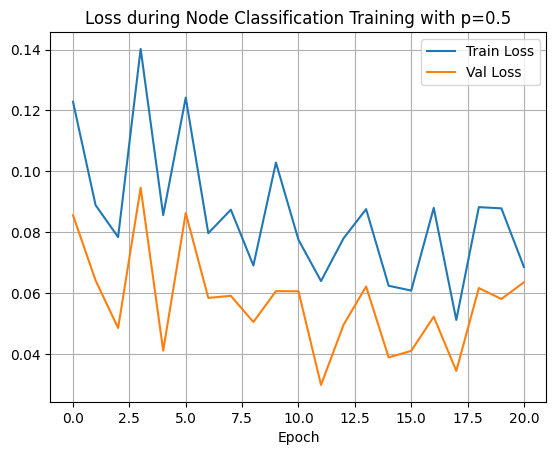

Epoch 000, Loss: 0.1292, Val Acc: 0.7280
Epoch 010, Loss: 0.1243, Val Acc: 0.7080
Epoch 020, Loss: 0.1412, Val Acc: 0.7200
Early stopping at epoch 24
Accuracy на тестовой выборке: 0.7890


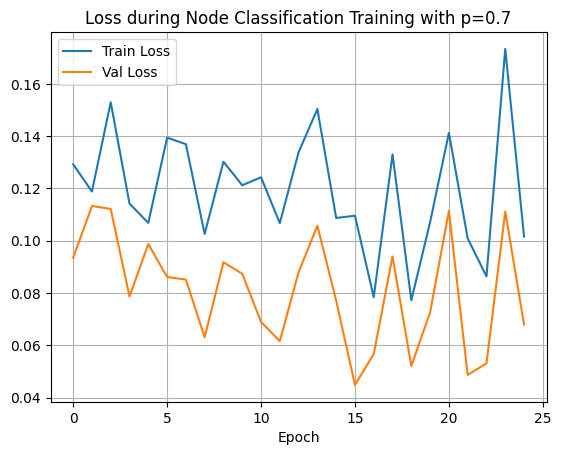

In [17]:
model = GCN_DropEdge(dataset.num_features, dataset.num_classes, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

for p in [0.1, 0.2, 0.3, 0.5, 0.7]:
    train_losses, val_losses = train_with_dropedge(model, data, optimizer, p, epochs=300, verbose=True)
    test_acc = evaluate_node_classification(model, data, data.test_mask)
    print(f"Accuracy на тестовой выборке: {test_acc:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.title(f"Loss during Node Classification Training with p={p}")
    plt.legend()
    plt.grid(True)
    plt.show()

1) Да. Модель стала меньше переобучатся и достигла более низкого лосса быстрее
2) Между 0.2 и 0.3, беря большие значения p, качество не улучшается

### 1.6 Исследование различных архитектур
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)

GraphSAGE
Epoch 000, Loss: 2.1232, Val Acc: 0.1280
Epoch 010, Loss: 0.0269, Val Acc: 0.7920
Epoch 020, Loss: 0.0032, Val Acc: 0.7840
Early stopping at epoch 24
Результаты GraphSAGE:
Train Accuracy: 0.9857
Val Accuracy: 0.8060
Test Accuracy: 0.8040


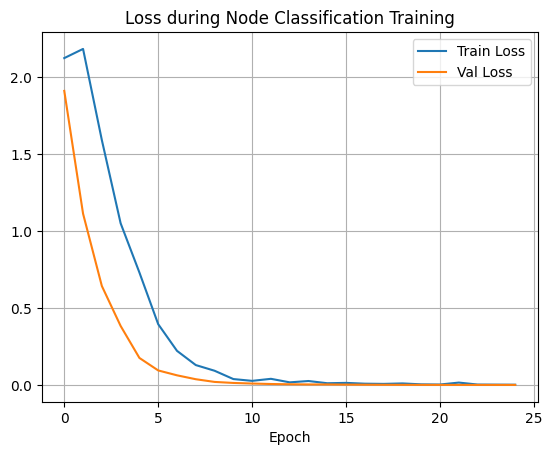

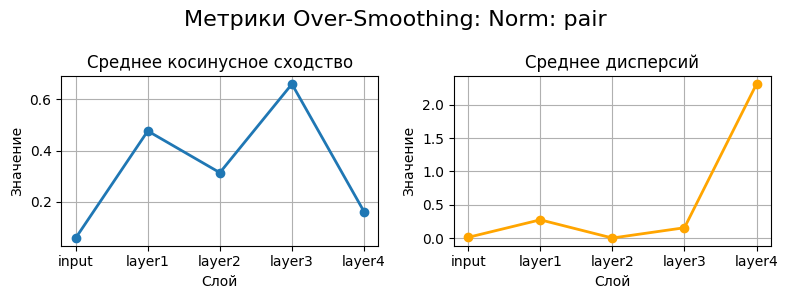

GAT
Epoch 000, Loss: 4.7177, Val Acc: 0.6560
Epoch 010, Loss: 0.4359, Val Acc: 0.7620
Epoch 020, Loss: 0.1799, Val Acc: 0.7760
Epoch 030, Loss: 0.1558, Val Acc: 0.7700
Epoch 040, Loss: 0.0820, Val Acc: 0.7720
Early stopping at epoch 42
Результаты GAT:
Train Accuracy: 1.0000
Val Accuracy: 0.7820
Test Accuracy: 0.7790


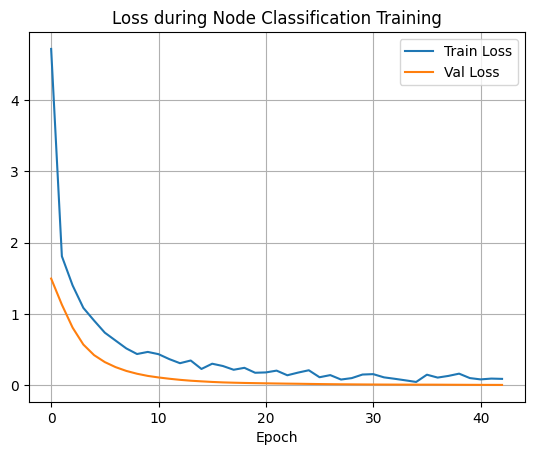

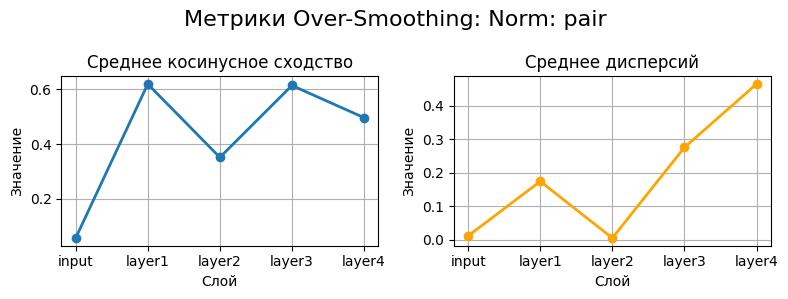

In [808]:
from torch_geometric.nn import SAGEConv, GATConv

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=64, dropout=0.5, use_norm=True):
        super().__init__()
        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, num_classes)
        self.dropout = dropout
        self.use_norm = use_norm
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = PairNorm()
        self.norm3 = nn.LayerNorm(hidden_dim)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv4(x, edge_index)
        
        return F.log_softmax(x, dim=1)

class GATModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=64, heads=8, dropout=0.5, use_norm=True):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, concat=False, dropout=dropout)
        self.conv4 = GATConv(hidden_dim, num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
        self.use_norm = use_norm
        
        self.norm1 = nn.LayerNorm(hidden_dim * heads)
        self.norm2 = PairNorm()
        self.norm3 = nn.LayerNorm(hidden_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(model_class, model_name, **model_kwargs):
    print(model_name)
    
    model = model_class(**model_kwargs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    
    train_losses, val_losses = train_node_classification(
        model, data, optimizer, epochs=200, patience=20, verbose=True
    )
    
    train_acc = evaluate_node_classification(model, data, data.train_mask)
    val_acc = evaluate_node_classification(model, data, data.val_mask)
    test_acc = evaluate_node_classification(model, data, data.test_mask)
    
    print(f"Результаты {model_name}:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.title("Loss during Node Classification Training")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    metrics = compute_smoothing_metrics(model, data, n_layers=4)
    plot_smoothing_metrics(metrics, f"Norm: {norm_type}", 4)

models_config = {
    'GraphSAGE': {
        'class': GraphSAGEModel,
        'kwargs': {
            'num_features': dataset.num_features,
            'num_classes': dataset.num_classes,
            'hidden_dim': 256,
            'dropout': 0.5,
        }
    },
    'GAT': {
        'class': GATModel,
        'kwargs': {
            'num_features': dataset.num_features,
            'num_classes': dataset.num_classes,
            'hidden_dim': 64,
            'heads': 64,
            'dropout': 0.2,
        }
    }
}

results = {}
for name, config in models_config.items():
    results[name] = train_and_evaluate(config['class'], name, **config['kwargs'])

# Часть 2. Link Prediction

### 2.1 Реализация MLP-декодера

Вместо dot-product декодера:

$
s_{uv} = z_u^\top z_v
$

реализуйте:

$
s_{uv} = \mathrm{MLP}([z_u ,||, z_v])
$

Сравните качество (AUC, AP) с dot-product.

In [87]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.lin1 = nn.Linear(in_dim * 2, 1)
        
    def forward(self, z_u, z_v):
        x = torch.cat([z_u, z_v], dim=-1)
        return self.lin1(x).squeeze()

class GCN_(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, 128)
        self.conv2 = GCNConv(128, out_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train_evaluate(decoder_type, neg_ratio=1.0):
    transform = RandomLinkSplit(is_undirected=True, split_labels=True, neg_sampling_ratio=neg_ratio)
    train_data, val_data, test_data = transform(data)
    train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)
    
    encoder = GCN_(data.num_features, 128).to(device)
    
    if decoder_type == 'mlp':
        decoder = MLP(128).to(device)
        def decode(z_u, z_v):
            return decoder(z_u, z_v)
    else:
        def decode(z_u, z_v):
            return (z_u * z_v).sum(dim=1)
    
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + (list(decoder.parameters()) \
            if decoder_type == 'mlp' \
            else []), 
        lr=0.01
    )
    
    encoder.train()
    if decoder_type == 'mlp':
        decoder.train()
    
    for _ in range(100):
        optimizer.zero_grad()
        z = encoder(train_data.x, train_data.edge_index)
        
        edge_idx = torch.cat([train_data.pos_edge_label_index, train_data.neg_edge_label_index], dim=1)
        labels = torch.cat([torch.ones(train_data.pos_edge_label_index.size(1)),
                          torch.zeros(train_data.neg_edge_label_index.size(1))]).to(device)
        
        z_u, z_v = z[edge_idx[0]], z[edge_idx[1]]
        pred = decode(z_u, z_v)
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        loss.backward()
        optimizer.step()
    
    encoder.eval()
    if decoder_type == 'mlp':
        decoder.eval()
    
    with torch.no_grad():
        z = encoder(test_data.x, test_data.edge_index)
        
        pos_score = decode(z[test_data.pos_edge_label_index[0]], z[test_data.pos_edge_label_index[1]])
        neg_score = decode(z[test_data.neg_edge_label_index[0]], z[test_data.neg_edge_label_index[1]])
        
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        
        auc = roc_auc_score(labels.cpu(), torch.sigmoid(scores).cpu())
        ap = average_precision_score(labels.cpu(), torch.sigmoid(scores).cpu())
    
    return auc, ap

auc_dot, ap_dot = train_evaluate('dot')
auc_mlp, ap_mlp = train_evaluate('mlp')

print(f"Baseline: AUC={auc_dot}, AP={ap_dot}")
print(f"MLP: AUC={auc_mlp}, AP={ap_mlp}")
print(f"Gain: {((auc_mlp/auc_dot)-1)*100}%\n")


Baseline: AUC=0.8025394757530154, AP=0.7885690848107135
MLP: AUC=0.6131187529480471, AP=0.6072369998038945
Gain: -23.602667348822514%



### 2.2 Эксперимент с negative sampling ratio

Попробуйте соотношения:

```
1:1, 1:2, 1:5, 1:10
```

Постройте таблицу для AUC и AP. Опишите полученные результаты


In [89]:
ratios = [1.0, 2.0, 5.0, 10.0]
results = []

for ratio in ratios:
    print(f"Ratio: {ratio}")
    auc_mlp, ap_mlp = train_evaluate('mlp', ratio)
    print(f"MLP: AUC={auc_mlp}, AP={ap_mlp}\n")


Ratio: 1.0
MLP: AUC=0.5927661103748793, AP=0.5949331669427439

Ratio: 2.0
MLP: AUC=0.6382260057051727, AP=0.5107858507782034

Ratio: 5.0
MLP: AUC=0.6499446104085713, AP=0.3882456999421984

Ratio: 10.0
MLP: AUC=0.6143512948945442, AP=0.23667109789334653



До соотношения 1:5 качество растет, но начиная с отношения 1:10, из-за слишком большого количества отрицательныьных примеров, качество начинает падать.

### 2.3 Оптизация текущей модели
Попробуйте улучшить текущую модель за счет использования следующих модификаций:
- добавление нормализации (BatchNorm / LayerNorm / PairNorm)
- Dropout
- residual connection

Опишите полученные результаты


In [94]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=512):
        super().__init__()
        self.lin1 = nn.Linear(in_dim * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, z_u, z_v):
        x = torch.cat([z_u, z_v], dim=-1)
        x = self.lin1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        return self.lin2(x).squeeze()

In [102]:
auc_dot, ap_dot = train_evaluate('dot')
auc_mlp, ap_mlp = train_evaluate('mlp')

print(f"Baseline: AUC={auc_dot}, AP={ap_dot}")
print(f"MLP: AUC={auc_mlp}, AP={ap_mlp}")
print(f"Gain: {((auc_mlp/auc_dot)-1)*100}%\n")

Baseline: AUC=0.7839617259270906, AP=0.7558792843075084
MLP: AUC=0.8497118213876597, AP=0.8511434523184053
Gain: 8.38690120781278%



In [105]:
ratios = [1.0, 2.0, 5.0, 10.0]
results = []

for ratio in ratios:
    print(f"Ratio: {ratio}")
    auc_mlp, ap_mlp = train_evaluate('mlp', ratio)
    print(f"MLP: AUC={auc_mlp}, AP={ap_mlp}\n")

Ratio: 1.0
MLP: AUC=0.8591603962175153, AP=0.8655283677505049

Ratio: 2.0
MLP: AUC=0.8454926888434671, AP=0.7532751176645096

Ratio: 5.0
MLP: AUC=0.8665871835762898, AP=0.7083098977037657

Ratio: 10.0
MLP: AUC=0.864222816199097, AP=0.5786308449589327



Благодоря добавлению улучшений, MLP показало себя гораздо луучше, чем в прошлый раз \
Добавление negative sampling подняло качество еще больше, из-за чего отрыв от baseline >5%

### 2.4 Реализация и сравнение GCN / GraphSAGE / GAT / GIN
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)


In [97]:
# TODO